# Introduction

This notebook is for accessing MODIS data related to snow cover using the Python package earthaccess. We will be accessing the MOD10A1F which is a Level 3 product giving snow cover at 500m resolution. The "F" means that grid cells in MOD10A1 (original snow cover product) that are obscured by cloud cover are filled by retaining clear-sky views of the surface from previous days. More on this product can be found [here](https://nsidc.org/data/mod10a1f/versions/61). Much of this code and its documentation is adapted from the [data access tutorials](https://github.com/snowex-hackweek/website-2024/tree/main/book/tutorials/Data_access) from the 2024 UW Hackweek. 

----------------------------------------------------------------------------------------------------------
Notebook by Lexi Arlen

August 2024

In [7]:
import earthaccess                                          # accessing earthdata
import json                                                 # defining the region from a geojson file   
from shapely.geometry import shape, GeometryCollection      # reformatting the geojson file
 
import rioxarray as rio

# For reading data, analysis and plotting
import xarray as xr
import hvplot.xarray

import pprint  # For nice printing of python objects

import logging

# Authentication
To access data you need to log in with your earthdata account (you may search without logging in). If you don't have one, you can make an account [here](https://urs.earthdata.nasa.gov/users/new).

In [11]:
auth = earthaccess.login()

Enter your Earthdata Login username:  alexisarlen
Enter your Earthdata password:  ········


# Querying available datasets
Next, we'll search for datasets containing the MODIS snow cover product *MOD10A1F*. Even though we know which product we want, it can be helpful to print the metadata from the dataset query to be sure our data query has the right parameters

In [12]:
query = earthaccess.search_datasets(keyword="MOD10A1F",)

Print the first 10 lines from the query, comprising the first two datasets.

In [15]:
for collection in query[:10]:
    pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
    print('')  # Add a space between collections for readability

{   'concept-id': 'C1646609734-NSIDC_ECS',
    'file-type': "[{'FormatType': 'Native', 'Format': 'HDF-EOS2', "
                 "'FormatDescription': 'HTTPS'}]",
    'get-data': [   'http://nsidc.org/daac/subscriptions.html',
                    'https://n5eil01u.ecs.nsidc.org/MOST/MOD10A1F.061/',
                    'https://search.earthdata.nasa.gov/search?q=MOD10A1F+V061',
                    'https://nsidc.org/data/data-access-tool/MOD10A1F/versions/61/'],
    'short-name': 'MOD10A1F',
    'version': '61'}

{   'concept-id': 'C2909924695-NSIDC_ECS',
    'file-type': "[{'FormatType': 'Native', 'Format': 'NetCDF', "
                 "'FormatDescription': 'HTTPS'}]",
    'get-data': [   'https://n5eil01u.ecs.nsidc.org/MOST/NSIDC-0791.001/',
                    'https://search.earthdata.nasa.gov/search?q=NSIDC-0791+V001',
                    'https://nsidc.org/data/data-access-tool/NSIDC-0791/versions/1/'],
    'short-name': 'NSIDC-0791',
    'version': '1'}



For each collection, `summary` returns a subset of fields from the collection metadata and Unified Metadata Model (UMM) entry.

- `concept-id` is an unique identifier for the collection that is composed of a alphanumeric code and the provider-id for the DAAC.
- `short-name` is the name of the dataset that appears on the dataset set landing page. For ICESat-2, `ShortNames` are generally how different products are referred to.
- `version` is the version of each collection.
- `file-type` gives information about the file format of the collection files.
- `get-data` is a collection of URL that can be used to access data, dataset landing pages, and tools.  

For _cloud-hosted_ data, there is additional information about the location of the S3 bucket that holds the data and where to get credentials to access the S3 buckets.  In general, you don't need to worry about this information because `earthaccess` handles S3 credentials for you.  Nevertheless it may be useful for troubleshooting. If you only want to search for data in the cloud, you add the additional argument `cloud_hosted=True`.

We see that the first dataset in the query is the one we're looking for. Now, lets access the data. 

# Accessing Data
Above is a query for datatsets, but now, we want to access data from a specefic region and time. The temporal range is identified with standard date strings, and latitude-longitude corners of a bounding box is specified.  Polygons and points, as well as shapefiles can also be specified.

For this project, we are looking at the 2020 water year for Grand Mesa, CO. A geojson file defining the region...

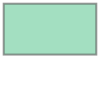

In [21]:
# Open a geojson of our area of interest
with open("./grand_mesa.geojson") as f:
    features = json.load(f)["features"]

grandmesa = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
grandmesa

### Parameters that go into the search_data function
**Data:**
- short_name = ''
- version = ''
- cloud_hosted = True/False
  
**Region:**
- bounding_box = (lon min, lat min, lon max, lat max)
- point = (lon, lat)

**Time frame:**
- temporal = ('yyyy-mm-dd', 'yyyy-mm-dd') start and end dates

**Other Parameters:**
- count = maximum number of returned results

For now, we'll get the set the bounding_box from the extent from the geojson file. I'm not sure what keyword to use if I wanted to preserve an irregular shape for the geojson file. Perhaps polygon? 

In [36]:
N = 100 

results = earthaccess.search_data(
    short_name = 'MOD10A1F',
    version = '61',
    cloud_hosted = True,
    bounding_box = grandmesa.bounds,
    temporal = ('2020-12-01','2021-07-01'),
    count = N
)

Now, let's display every 20th file we've found.

In [37]:
for i, r in enumerate(results):
    if i % 20 == 0:
        display(r)

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-12-01T00:00:00.000Z', 'EndingDateTime': '2020-12-01T23:59:59.000Z'}}
Size(MB): 1.26888
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2020.12.01/MOD10A1F.A2020336.h09v05.061.2020357073222.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-12-21T00:00:00.000Z', 'EndingDateTime': '2020-12-21T23:59:59.000Z'}}
Size(MB): 2.32748
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2020.12.21/MOD10A1F.A2020356.h09v05.061.2021011221611.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-01-10T00:00:00.000Z', 'EndingDateTime': '2021-01-10T23:59:59.000Z'}}
Size(MB): 2.26107
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.01.10/MOD10A1F.A2021010.h09v05.061.2021020212253.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-01-30T00:00:00.000Z', 'EndingDateTime': '2021-01-30T23:59:59.000Z'}}
Size(MB): 2.62045
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.01.30/MOD10A1F.A2021030.h09v05.061.2021040051437.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-02-19T00:00:00.000Z', 'EndingDateTime': '2021-02-19T23:59:59.000Z'}}
Size(MB): 4.61654
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.02.19/MOD10A1F.A2021050.h09v05.061.2021055020438.hdf']

Clicking on the image shoes that the more red, the larger percent snow in the given 500m pixel. We see that as time goes on, more snow accumulates, which makes sense as these images are ordered chronologically staring at the beginning of winter. 

The query I made required the data to be cloud hosted, but it seems like the data isn't. Maybe if there isn't any cloud hosted data, the search ignore the cloud_hosted demand. 

In [8]:
ds = xr.open_dataset('MOD10A1F.A2020336.h09v05.061.2020357073222.hdf', engine = 'rasterio')

In [9]:
ds

<xarray.Dataset> Size: 115MB
Dimensions:                  (band: 1, x: 2400, y: 2400)
Coordinates:
  * band                     (band) int64 8B 1
  * x                        (x) float64 19kB -1.001e+07 ... -8.896e+06
  * y                        (y) float64 19kB 4.448e+06 4.447e+06 ... 3.336e+06
    spatial_ref              int64 8B ...
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 23MB ...
    Cloud_Persistence        (band, y, x) float32 23MB ...
    Basic_QA                 (band, y, x) float32 23MB ...
    Algorithm_Flags_QA       (band, y, x) float32 23MB ...
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 23MB ...
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

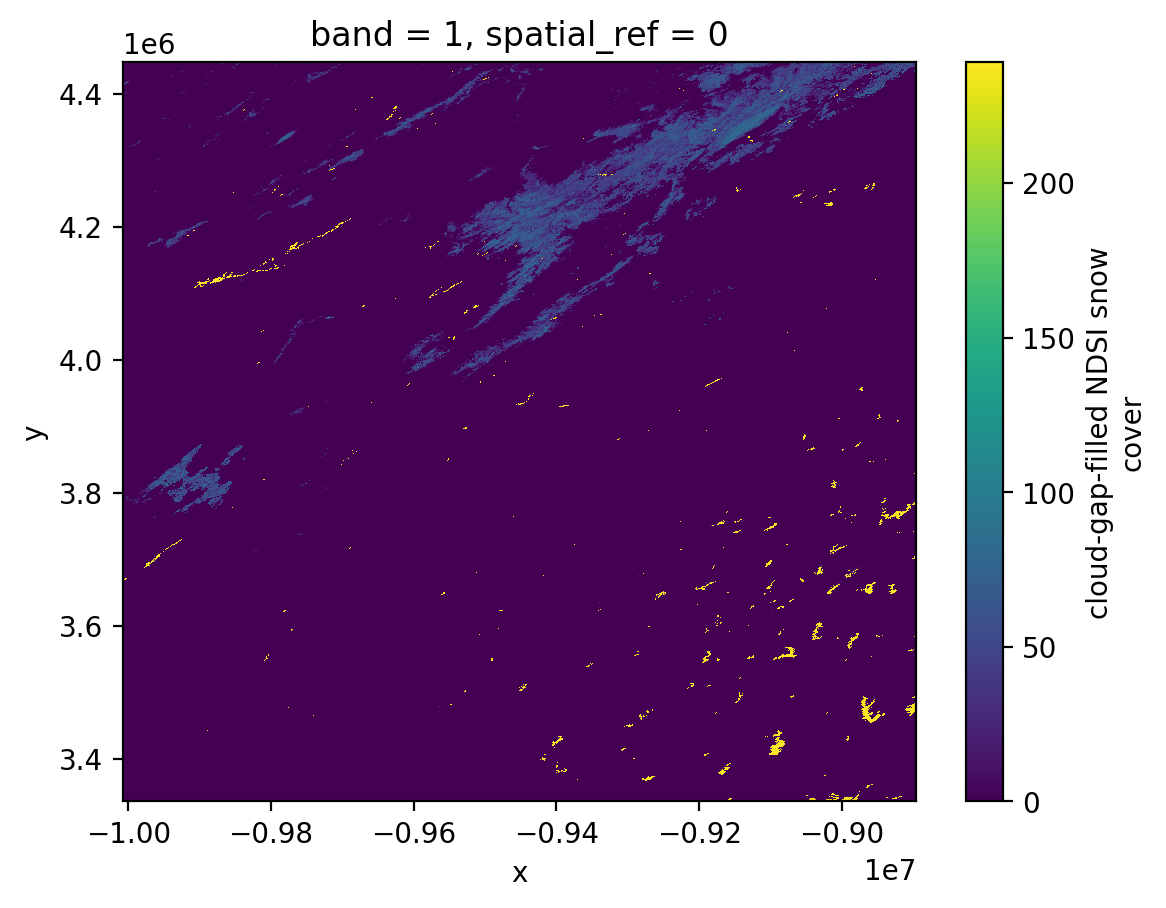

In [10]:
ds['CGF_NDSI_Snow_Cover'].plot()

In [11]:
ds['CGF_NDSI_Snow_Cover'].max()

<xarray.DataArray 'CGF_NDSI_Snow_Cover' ()> Size: 4B
array(239., dtype=float32)
Coordinates:
    spatial_ref  int64 8B ...

ds.rio.reproject_match

In [12]:
ds_reprojected = ds.rio.reproject('EPSG:4326') # lat lon

In [13]:
ds_reprojected

<xarray.Dataset> Size: 79MB
Dimensions:                  (x: 3153, y: 1256, band: 1)
Coordinates:
  * x                        (x) float64 25kB -117.5 -117.5 ... -92.39 -92.38
  * y                        (y) float64 10kB 40.0 39.99 39.98 ... 30.01 30.0
  * band                     (band) int64 8B 1
    spatial_ref              int64 8B 0
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Cloud_Persistence        (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Basic_QA                 (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Algorithm_Flags_QA       (band, y, x) float32 16MB nan 0.0 0.0 ... 64.0 64.0
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import numpy as np
%config InlineBackend.figure_format = 'png2x'

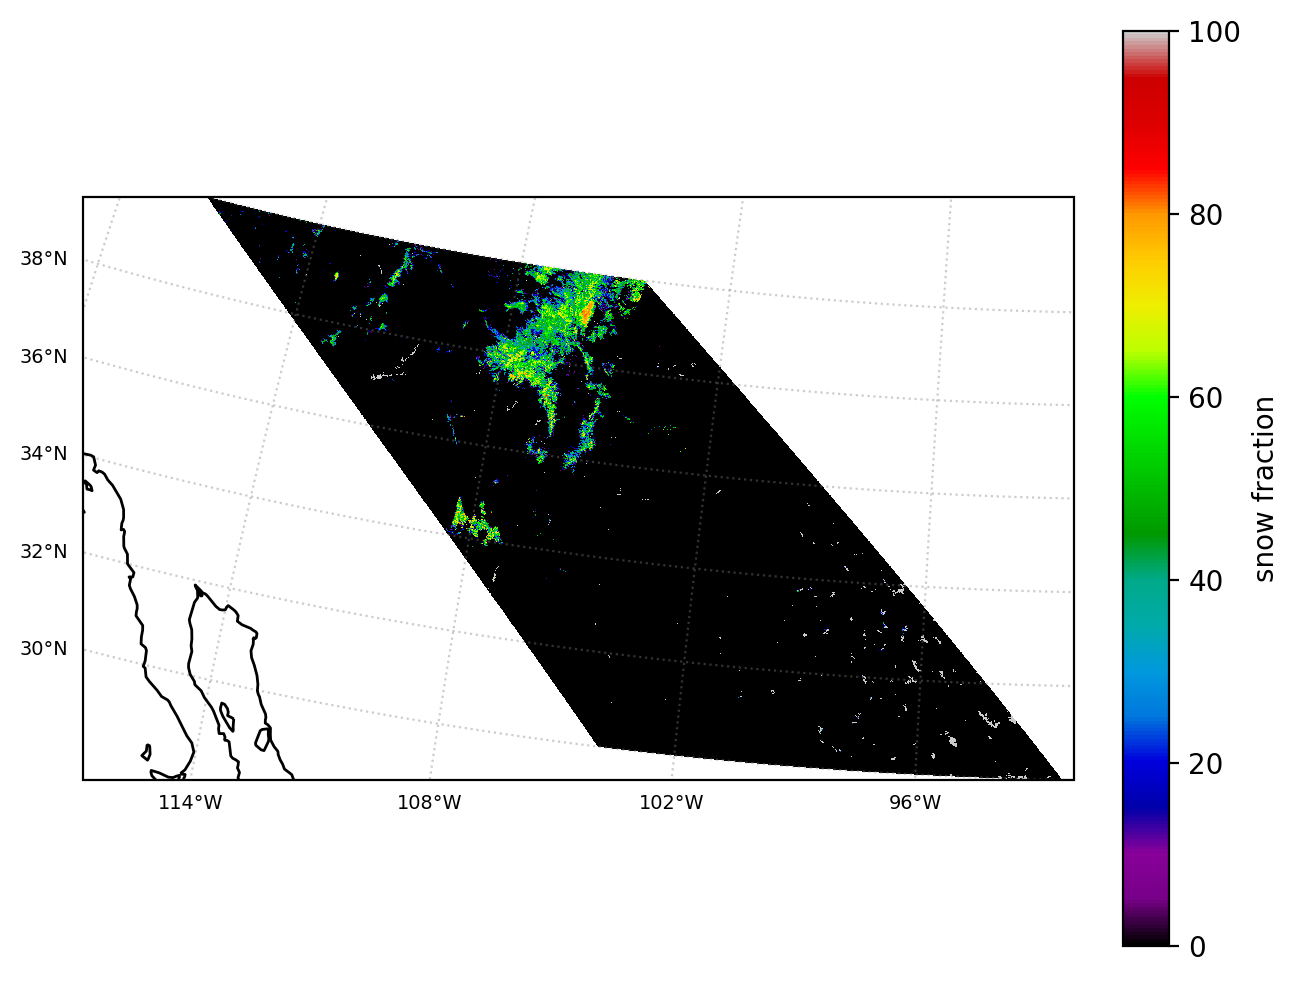

In [15]:
fig = plt.figure(layout = 'constrained')
#map_extent = list(grandmesa.bounds)
proj = ccrs.Orthographic(-90, 30)

ax = fig.add_subplot(1, 1, 1, projection=proj)
#ax.set_extent(map_extent)#,crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, zorder= 10)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.4)
gl.xlocator = mticker.FixedLocator(np.linspace(-120, -90, 6))
gl.ylocator = mticker.FixedLocator(np.linspace(30, 40, 6))
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'size': 'x-small'}
gl.ylabel_style = {'size': 'x-small'}

# Plot the image data
cm = plt.pcolormesh(ds_reprojected['x'], ds_reprojected['y'], 
                    ds_reprojected['CGF_NDSI_Snow_Cover'][0, :, :], cmap = 'nipy_spectral',
                    vmin = 0, vmax = 100, transform = ccrs.PlateCarree())
plt.colorbar(cm, label = 'snow fraction')
plt.show()